## NEURAL STYLE TRANSFER LEARNING USING VGG19-CNN

Image style uses:
    style of paint strokes or style of painting technique used. SO, Image content+ style of image resulting the target image.
Capable of producing new images that are tough to produce originally.

In [1]:
%matplotlib inline 
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

### USING VGG19 
style transfer needs vast amount of training as  well as large datasets to train on to get an efficient model. Henceforth, we 
make use of the pretrained model VGG19 along with the moderate sized dataset and fine tune the model slightly. 

##### NOTE: vgg19 model has 3 more CNN layers than the vgg16

In [2]:
vgg=models.vgg19(pretrained=True).features
#here we're importing only the features. But, no Fully connected layers. Hence only those layers are being shown here.
for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

The target image will be the conbination of content from the content image and style from the style image. 
Here, szize of the style image has to be equal to the size of the content image for the effective transformation. That would make things easier. here, we make the style image equal to content image.

In [4]:
def load_image(img_path, max_size=400, shape=None):#image path, image size, shape
    image = Image.open(img_path).convert('RGB')#import and and convert to RGB 3 channel format
    if max(image.size) > max_size:#if highest dimension of an image if it is hor or vert 
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None: 
        size = shape
 
    in_transform = transforms.Compose([
                        transforms.Resize(size),#maintains the aspect ratio. the scaling takes place here
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,))
                    ])
    image = in_transform(image).unsqueeze(0)#to add the extra layer of dim to image.
    return image

In [5]:
content = load_image('City.jpg').to(device)
style = load_image('StarryNight.jpg', shape=content.shape[-2:]).to(device)#making the style image size equal to the content image.

In [6]:
def im_convert(tensor):
    image=tensor.cpu().clone().detach().numpy() #first dim= color, second= width, third =height, 
    image=image.squeeze()#removing the single dim data
    image= image.transpose(1, 2, 0) #swap axis 0 to 1 and 1 to 2 and 2 to 0
#normalizaion = Z= (x-mean)/SD. So, we do this:  
    image =image*np.array((0.5, 0.5, 0.5))+ np.array((0.5, 0.5, 0.5))
    image=image.clip(0, 1) #to ensure the values are in betn 0 and 1
    return image

(-0.5, 599.5, 399.5, -0.5)

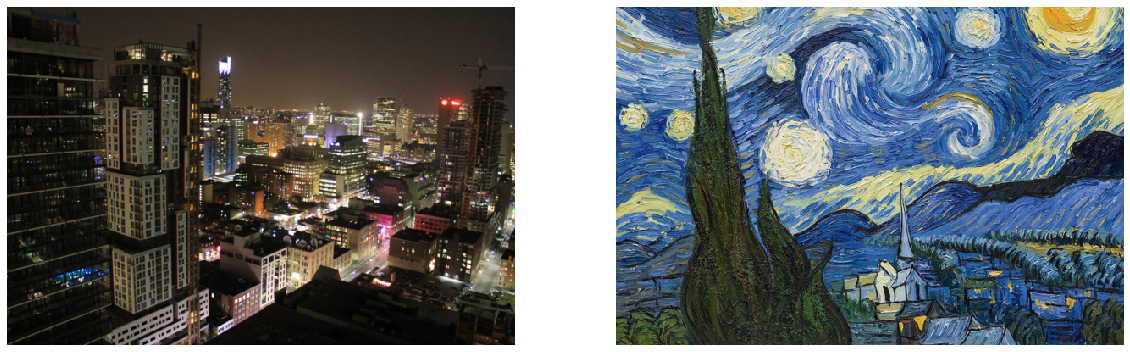

In [7]:
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(20, 10))#1 row and 2 cols and returning subplot call to apopriate fig and axis 1 and w
ax1.imshow(im_convert(content))
ax1.axis("off")
ax2.imshow(im_convert(style))
ax2.axis("off")

the content features of the target image has to match to the features of the content image and the style features of the target image has to be matched to the features of the style image

layers 0, 5, 10, 19, 21, 28 were chosen from the VGG19 model according to the paper chosen to extract features. We use 5 of them for style extraction and one for content extraction. Whereas, extrcting styles from the various layers makes up for the effective style transfer to the target image

In [8]:
def get_features(image, model):
    layers = {'0': 'conv1_1',
              '5': 'conv2_1', 
              '10': 'conv3_1', 
              '19': 'conv4_1',
              '21': 'conv4_2',  # Content Extraction
              '28': 'conv5_1'}
    #now, pass the image through the given layers only and extracting the features(outputs) of the respective layers and storing it in the dictionary with keys as names
    features = {}
 
    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image #extract outputs into features dictionary           
    return features

In [9]:
content_features=get_features(content, vgg)
style_features=get_features(style, vgg)

#### Gram Matrix.
Gram matrix is  the V(transform)*V where V is the arbitrary vector
Here, we apply gram matrix to matrix extracted from the Convolutional neural networks to preserve the textural features like shapes and positioning from the image. Even though the content features may vanish but the style features are efficiently extracted using this matrix

In [10]:
def gram_matrix(tensor):#param is the image tensor. Here, we have tensor of 4Dim. 
    #so, we have to convert (resize) the tensor to one d in order to apply gram matrix
    _, d, h, w=tensor.size()#batch size, depth, height, width
    tensor=tensor.view(d, h*w)
    gram=torch.mm(tensor, tensor.t())#multiplication
    return gram

### Applying the gram matrix to the features extracted earlier

Weight parameters:
    
    > 1. We can prioritize certain layers using weight parameters on each layer as the layers initial are more effective in recreating the style features and the later features adds additional variety.
    
    > 2. Another weight matrix is the weight of balance between the style image and the content image in the target image. to refer the ratio betn style and content. given by alpha and beta. 
 ##### note: The lower the ratio gets, the more "style based"  the  image gets

In [11]:
style_grams={layer: gram_matrix(style_features[layer]) for layer in style_features}

In [12]:
#here layer 4_2 is not used as it  is  solely used for the content extraction.  
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}
content_weight=1 #alpha
style_weight=1e6 #beta

### procedure:
The target image is being set as the clone of the content image at first but, the requires_grad is toggled to true in order to apply the styles from the style image to bring out the targer images after the required epoches using Optimization procedure, which tries to maintain the CONTENT of the image.

In [13]:
target=content.clone().requires_grad_(True).to(device) #as this is involved in optimization, connect it to gpu

In [14]:
show_every=300 #to get the image after every 300 iterations
optimizer=optim.Adam([target], lr=0.003)
#steps: the more steps we take the more efficient results. However, we have to maintain the balance betn results and time efficiency
steps=2100

height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps/300
counter = 0

Total loss:  2887857.5
Iteration:  300


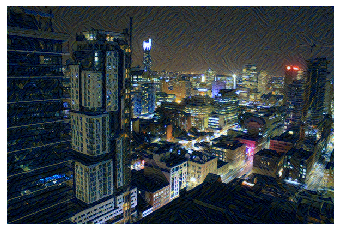

Total loss:  949915.0625
Iteration:  600


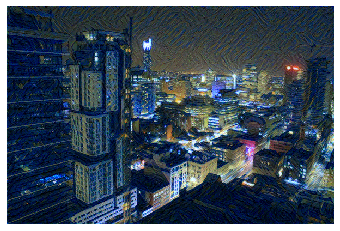

Total loss:  658557.6875
Iteration:  900


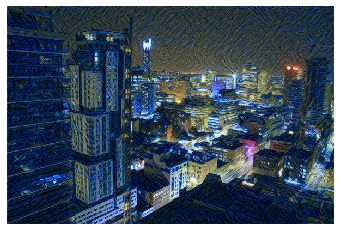

Total loss:  510564.4375
Iteration:  1200


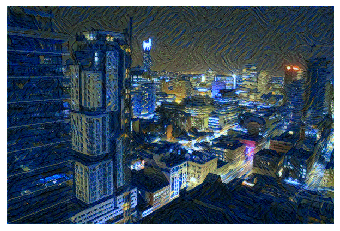

Total loss:  400885.78125
Iteration:  1500


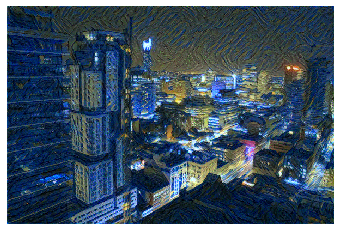

Total loss:  315106.4375
Iteration:  1800


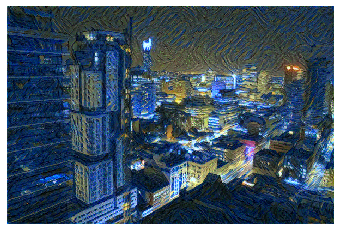

Total loss:  247007.296875
Iteration:  2100


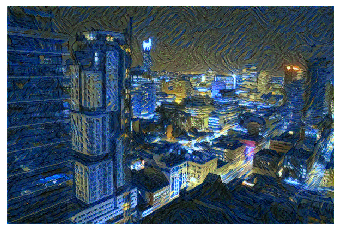

In [15]:
for ii in range(1, steps+1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    style_loss = 0
  
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)
  
    total_loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
  
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        print('Iteration: ', ii)
        plt.imshow(im_convert(target))
        plt.axis("off")
        plt.show()
    
    if ii % capture_frame == 0:
        image_array[counter] = im_convert(target)
        counter = counter + 1